# 03 - Baselines Probabilísticos (v2, para o novo travel_features_rich)

Neste notebook implementamos dois baselines para o novo dataset enriquecido:

1. **Baseline 1 – Regressão Linear Gaussiana**
   - Usa features numéricas + one-hot de categorias (incluindo `rideable_type` e `member_casual`).
   - Prediz a média condicional do tempo de viagem (no espaço log-transformado).
   - Estima um desvio-padrão global dos resíduos e constrói intervalos 10–90% assumindo Normal.

2. **Baseline 2 – Distribuição Histórica Condicional**
   - Usa o dataset no espaço original (sem scaling).
   - Para cada contexto `(hour, weekday, is_rainy, is_peak_hour)` recupera as durações históricas.
   - Usa esses samples como distribuição empírica (média + quantis 10/50/90) com fallbacks.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

from collections import defaultdict
from tqdm import tqdm
import math

plt.rcParams['figure.figsize'] = (6, 6)

DATA_PATH = "data/processed/travel_features_rich.csv"

df = pd.read_csv(DATA_PATH)
print("Dataset shape:", df.shape)
print(df.head())


Dataset shape: (1679452, 29)
   duration_min  hour  weekday  distance_km  rideable_type member_casual  \
0      2.550000    17        2     1.044301  electric_bike        member   
1     13.734617    23        4     1.727745   classic_bike        member   
2     11.842950    19        2     1.807678  electric_bike        member   
3      4.060483    12        3     0.468681   classic_bike        member   
4     23.020733    10        5     0.468681   classic_bike        member   

   is_peak_hour  is_rainy  is_snowy  temp  ...  windspeed  winddir  \
0             1         0         0  11.3  ...       11.1    264.0   
1             0         0         0   8.3  ...       17.4    272.0   
2             1         0         0  10.5  ...        8.9    291.0   
3             0         0         0   2.5  ...       16.6    233.0   
4             1         0         0   4.1  ...       17.3    318.0   

   sealevelpressure  cloudcover  visibility solarradiation  solarenergy  \
0            1023.

## Baseline 1 – Regressão Linear com ruído Gaussiano global

In [2]:
# ===== Preparação dos dados para o Baseline 1 =====

target_col = "duration_min"

numeric_cols = [
    "hour", "weekday",
    "distance_km",
    "is_peak_hour", "is_rainy", "is_snowy",
    "temp", "feelslike", "dew", "humidity",
    "precip", "precipprob", "snow", "snowdepth",
    "windgust", "windspeed", "winddir",
    "sealevelpressure", "cloudcover",
    "visibility", "solarradiation", "solarenergy",
    "uvindex"
]

cat_cols = ["rideable_type", "member_casual", "preciptype", "conditions", "icon"]

all_cols = [target_col] + numeric_cols + cat_cols
df_model = df[all_cols].copy()

df_cat = pd.get_dummies(df_model[cat_cols], drop_first=True)
df_num = df_model[numeric_cols]

X_full = pd.concat([df_num, df_cat], axis=1)
y_raw = df_model[target_col].values.astype(np.float32)

print("Total features after one-hot:", X_full.shape[1])

y_log = np.log1p(y_raw)

X_train, X_test, y_train, y_test = train_test_split(
    X_full.values, y_log, test_size=0.2, random_state=42
)

print("Train size:", X_train.shape[0])
print("Test size:",  X_test.shape[0])

x_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled  = x_scaler.transform(X_test)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled  = y_scaler.transform(y_test.reshape(-1, 1)).flatten()


Total features after one-hot: 40
Train size: 1343561
Test size: 335891


In [3]:
# ===== Treino do modelo LinearRegression =====

linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train_scaled)

y_pred_scaled = linreg.predict(X_test_scaled)

residuals = y_test_scaled - y_pred_scaled
sigma_hat = residuals.std()

print("Estimated residual std (sigma_hat):", sigma_hat)

y_pred_log = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_log = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

y_pred_minutes = np.expm1(y_pred_log)
y_test_minutes = np.expm1(y_test_log)

mae = mean_absolute_error(y_test_minutes, y_pred_minutes)
rmse = math.sqrt(mean_squared_error(y_test_minutes, y_pred_minutes))

print(f"[LinearRegression] Test MAE:  {mae:.3f}")
print(f"[LinearRegression] Test RMSE: {rmse:.3f}")


Estimated residual std (sigma_hat): 0.6874755963530234
[LinearRegression] Test MAE:  4.329
[LinearRegression] Test RMSE: 14.046


In [4]:
# ===== Intervalos 10–90% assumindo Normal global =====

z10 = -1.2816
z90 =  1.2816

y_pred_low_scaled  = y_pred_scaled + z10 * sigma_hat
y_pred_high_scaled = y_pred_scaled + z90 * sigma_hat

y_pred_low_log  = y_scaler.inverse_transform(y_pred_low_scaled.reshape(-1, 1)).flatten()
y_pred_high_log = y_scaler.inverse_transform(y_pred_high_scaled.reshape(-1, 1)).flatten()

y_pred_low_minutes  = np.expm1(y_pred_low_log)
y_pred_high_minutes = np.expm1(y_pred_high_log)

coverage_10_90 = ((y_test_minutes >= y_pred_low_minutes) &
                  (y_test_minutes <= y_pred_high_minutes)).mean()

print(f"[LinearRegression] 10–90% interval coverage: {coverage_10_90*100:.1f}%")


[LinearRegression] 10–90% interval coverage: 85.1%


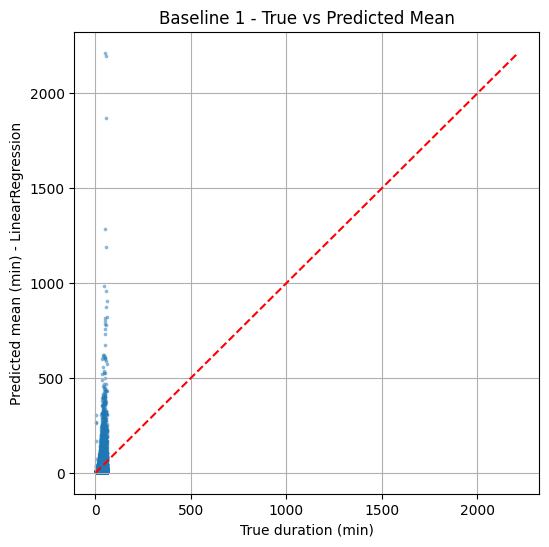

In [5]:
# ===== Gráfico True vs Predicted (média) =====

plt.figure(figsize=(6,6))
plt.scatter(y_test_minutes, y_pred_minutes, s=3, alpha=0.4)
min_v = min(y_test_minutes.min(), y_pred_minutes.min())
max_v = max(y_test_minutes.max(), y_pred_minutes.max())
plt.plot([min_v, max_v],[min_v, max_v],'r--')
plt.xlabel("True duration (min)")
plt.ylabel("Predicted mean (min) - LinearRegression")
plt.title("Baseline 1 - True vs Predicted Mean")
plt.grid(True)
plt.show()


## Baseline 2 – Distribuição histórica condicional

In [6]:
# ===== Preparação dos dados para o Baseline 2 =====

df_hist = df_model.copy()

# Adicionar as flags extras de contexto
for col in ["is_rainy", "is_peak_hour"]:
    df_hist[col] = df[col].values

df_hist["row_id"] = np.arange(len(df_hist))

train_idx, test_idx = train_test_split(
    df_hist["row_id"].values,
    test_size=0.2,
    random_state=42
)

train_mask = df_hist["row_id"].isin(train_idx)
test_mask  = df_hist["row_id"].isin(test_idx)

df_train_hist = df_hist[train_mask].copy()
df_test_hist  = df_hist[test_mask].copy()

print("Hist baseline - train size:", len(df_train_hist), " test size:", len(df_test_hist))

def build_key(df_):
    return list(zip(df_["hour"], df_["weekday"], df_["is_rainy"], df_["is_peak_hour"]))

df_train_hist["ctx_key"] = build_key(df_train_hist)
df_test_hist["ctx_key"]  = build_key(df_test_hist)


Hist baseline - train size: 1343561  test size: 335891


In [7]:
# ===== Construir dicionários de buckets =====

bucket_durations = defaultdict(list)
print("Building bucket_durations...")
for _, row in tqdm(df_train_hist.iterrows(), total=len(df_train_hist), desc="Building buckets"):
    bucket_durations[row["ctx_key"]].append(row["duration_min"])

print("Total buckets (hour, weekday, is_rainy, is_peak_hour):", len(bucket_durations))

bucket_hwr = defaultdict(list)  # (hour, weekday, is_rainy)
bucket_hw  = defaultdict(list)  # (hour, weekday)
bucket_h   = defaultdict(list)  # hour

print("Building fallback buckets...")
for _, row in tqdm(df_train_hist.iterrows(), total=len(df_train_hist), desc="Building fallbacks"):
    key_hwr = (row["hour"], row["weekday"], row["is_rainy"])
    key_hw  = (row["hour"], row["weekday"])
    key_h   = row["hour"]

    bucket_hwr[key_hwr].append(row["duration_min"])
    bucket_hw[key_hw].append(row["duration_min"])
    bucket_h[key_h].append(row["duration_min"])

global_durations = df_train_hist["duration_min"].values


Building bucket_durations...


Building buckets: 100%|██████████| 1343561/1343561 [00:22<00:00, 59208.39it/s]


Total buckets (hour, weekday, is_rainy, is_peak_hour): 216
Building fallback buckets...


Building fallbacks: 100%|██████████| 1343561/1343561 [00:30<00:00, 43976.57it/s]


In [8]:
def get_bucket_samples(ctx_key, hour, weekday, is_rainy, min_size=30):
    samples = bucket_durations.get(ctx_key, [])
    if len(samples) >= min_size:
        return np.array(samples)

    key_hwr = (hour, weekday, is_rainy)
    samples = bucket_hwr.get(key_hwr, [])
    if len(samples) >= min_size:
        return np.array(samples)

    key_hw = (hour, weekday)
    samples = bucket_hw.get(key_hw, [])
    if len(samples) >= min_size:
        return np.array(samples)

    samples = bucket_h.get(hour, [])
    if len(samples) >= min_size:
        return np.array(samples)

    return global_durations


In [9]:
# ===== Gerar quantis e média para o conjunto de teste =====

q10_hist = []
q50_hist = []
q90_hist = []
mean_hist = []

print("Generating predictions for test set...")
for _, row in tqdm(df_test_hist.iterrows(), total=len(df_test_hist), desc="Predicting"):
    ctx_key = row["ctx_key"]
    hour = row["hour"]
    weekday = row["weekday"]
    is_rainy = row["is_rainy"]

    samples = get_bucket_samples(ctx_key, hour, weekday, is_rainy, min_size=30)
    q10_hist.append(np.percentile(samples, 10))
    q50_hist.append(np.percentile(samples, 50))
    q90_hist.append(np.percentile(samples, 90))
    mean_hist.append(samples.mean())

q10_hist = np.array(q10_hist)
q50_hist = np.array(q50_hist)
q90_hist = np.array(q90_hist)
mean_hist = np.array(mean_hist)

y_test_hist = df_test_hist["duration_min"].values

mae_hist  = mean_absolute_error(y_test_hist, mean_hist)
rmse_hist = math.sqrt(mean_squared_error(y_test_hist, mean_hist))
coverage_hist = ((y_test_hist >= q10_hist) & (y_test_hist <= q90_hist)).mean()

print(f"\n[HistBaseline] Test MAE (mean of bucket):  {mae_hist:.3f}")
print(f"[HistBaseline] Test RMSE (mean of bucket): {rmse_hist:.3f}")
print(f"[HistBaseline] 10-90% interval coverage:   {coverage_hist*100:.1f}%")


Generating predictions for test set...


Predicting: 100%|██████████| 335891/335891 [04:42<00:00, 1188.90it/s]


[HistBaseline] Test MAE (mean of bucket):  6.484
[HistBaseline] Test RMSE (mean of bucket): 8.937
[HistBaseline] 10-90% interval coverage:   79.9%


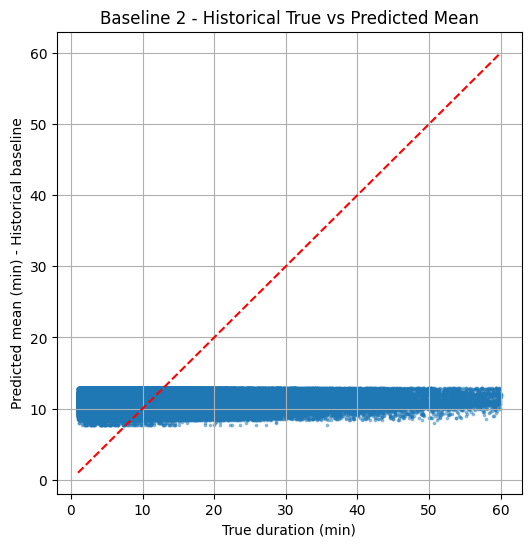

In [10]:
# ===== Gráfico True vs Predicted Mean (Histórico) =====

plt.figure(figsize=(6,6))
plt.scatter(y_test_hist, mean_hist, s=3, alpha=0.4)
min_v = min(y_test_hist.min(), mean_hist.min())
max_v = max(y_test_hist.max(), mean_hist.max())
plt.plot([min_v, max_v],[min_v, max_v],'r--')
plt.xlabel("True duration (min)")
plt.ylabel("Predicted mean (min) - Historical baseline")
plt.title("Baseline 2 - Historical True vs Predicted Mean")
plt.grid(True)
plt.show()
